In [17]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax_sbgeom as jsb
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as onp
import sys 
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import StellBlanket.SBGeom as SBGeom
from functools import partial
import jax_sbgeom.flux_surfaces.flux_surface_meshing as fsm
import jax_sbgeom.flux_surfaces.flux_surfaces_base as fsb
import jax_sbgeom.flux_surfaces.flux_surfaces_extended as fse
from jax_sbgeom.jax_utils.utils import _mesh_to_pyvista_mesh
import pyvista as pv
from dataclasses import dataclass
import h5py


vmec_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"]
coil_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"]
stell_i = 1
vmec_file = vmec_files[stell_i]
coil_file = coil_files[stell_i]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def _get_extended_no_phi_flux_surfaces(vmec_file):    
    fs_jax    = jsb.flux_surfaces.FluxSurfaceNormalExtendedNoPhi.from_hdf5(vmec_file)
    fs_sbgeom = SBGeom.Flux_Surfaces_Normal_Extended_No_Phi(SBGeom.VMEC.Flux_Surfaces_From_HDF5(vmec_file))
    return fs_jax, fs_sbgeom


def _get_discrete_coils(coil_file):
    with h5py.File(coil_file, 'r') as f:
        coil_data = jnp.array(f['Dataset1'])

    return jsb.coils.CoilSet.from_list([jsb.coils.DiscreteCoil.from_positions(coil_data[i]) for i in range(coil_data.shape[0])])

fs_jax, fs_sbgeom = _get_extended_no_phi_flux_surfaces(vmec_file)  # just to compile
coilset_jax       = _get_discrete_coils(coil_file)

import jax_sbgeom.jax_utils.raytracing as RT

In [33]:
sarr, coilset = jsb.coils.coil_winding_surface.optimize_coil_surface(coilset_jax, n_samples_per_coil=  300)

In [34]:
positions_coilset = coilset.position_different_s(jsb.coils.coil_winding_surface._create_total_s(sarr[0], coilset.n_coils))
vertices = jsb.flux_surfaces.flux_surface_meshing._mesh_surface_connectivity(positions_coilset.shape[1], positions_coilset.shape[0], True, True)
positions_standard_ordering = jnp.moveaxis(positions_coilset, 0, 1) # ntheta, nphi [number of coils], 3
mesh_pv_cws = _mesh_to_pyvista_mesh(positions_standard_ordering.reshape(-1,3), vertices)
mesh_cws_def = (positions_standard_ordering.reshape(-1,3), vertices)
mesh_lcfs = jsb.flux_surfaces.flux_surface_meshing.mesh_surface(fs_jax, 1.0, jsb.flux_surfaces.ToroidalExtent.full(), 50,60)

theta = 0.26
phi = 0.235

theta = jnp.linspace(0, 2 * jnp.pi, 610)
phi   = jnp.linspace(0, 2 * jnp.pi / fs_jax.settings.nfp, 100)
theta, phi = jnp.meshgrid(theta, phi, indexing='ij')
positions_lcfs_mg = fs_jax.cartesian_position(1.0,  theta, phi)
directions_lcfs_mg = fs_jax.cartesian_position(2.0, theta, phi) - positions_lcfs_mg

theta = 0.26
phi = 0.235
positions_lcfs = fs_jax.cartesian_position(1.0,  theta, phi)
directions_lcfs = fs_jax.cartesian_position(2.0, theta, phi) - positions_lcfs


In [35]:
#bvh = RT.build_lbvh(mesh_cws_def[0], mesh_cws_def[1])

In [ ]:
@jax.jit
def find_minimum_distance_from_bvh(points, directions, mesh):
    bvh = RT.build_lbvh(mesh[0], mesh[1])
    hits_possible = RT.ray_traversal_bvh_vectorized(bvh, points, directions)    
    mesh_total = jnp.moveaxis(mesh[0][mesh[1][bvh.order[hits_possible]]], -3, 0)
    return jnp.nanmin(RT.ray_triangle_intersection_vectorized(points, directions, mesh_total), axis=0)

In [37]:
bvh= RT.build_lbvh(*mesh_cws_def)

In [38]:
%timeit RT.ray_traversal_bvh_vectorized(bvh, positions_lcfs_mg, directions_lcfs_mg)

4.1 s ± 491 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


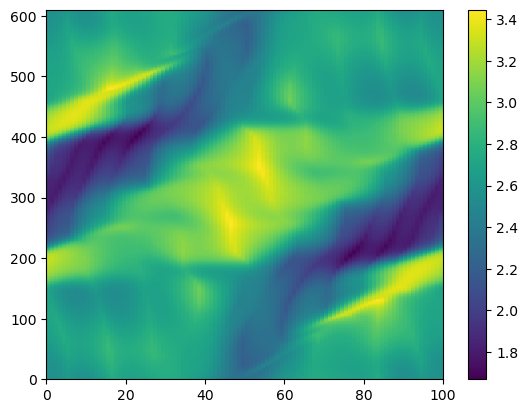

In [26]:
import matplotlib.pyplot as plt
dmesh = find_minimum_distance_from_bvh(positions_lcfs_mg, directions_lcfs_mg, mesh_cws_def)    

plt.pcolormesh(dmesh)
plt.colorbar()